<a href="https://colab.research.google.com/github/rosan-international/video_classifier_bugs/blob/main/quantizing_movinet_stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 Rosan International Consulting and Research SL

# Transfer learning for video classification with MoViNet

MoViNets (Mobile Video Networks) provide a family of efficient video classification models, supporting inference on streaming video. We take a pre-trained MoViNet model to classify seizures. A pre-trained model is a saved network that was previously trained on a larger dataset. You can find more details about MoViNets in the [MoViNets: Mobile Video Networks for Efficient Video Recognition](https://arxiv.org/abs/2103.11511) paper by Kondratyuk, D. et al. (2021). This notebook will: 

* Download a pre-trained MoViNet model
* Create a new model using a pre-trained model with a new classifier by freezing the convolutional base of the MoViNet model
* Replace the classifier head with the number of labels of a new dataset
* Perform transfer learning on the seizures dataset
* Export the trained/tuned MoViNet-A0-Stream model
* Illustrate streaming action recognition with a sample video

The model downloaded in this notebook is from [official/projects/movinet](https://github.com/tensorflow/models/tree/master/official/projects/movinet). This repository contains a collection of MoViNet models that TF Hub uses in the TensorFlow 2 SavedModel format. The transfer learning strategy is adapted from https://github.com/tensorflow/models/blob/master/official/projects/movinet/movinet_streaming_model_training_and_inference.ipynb



# Setup

## Install Libraries

In [1]:
!pip install git+https://github.com/okankop/vidaug.git
!pip install apache_beam
import vidaug 
from vidaug import augmentors as va

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/okankop/vidaug.git to /tmp/pip-req-build-nbtpevhm
  Running command git clone --filter=blob:none --quiet https://github.com/okankop/vidaug.git /tmp/pip-req-build-nbtpevhm
  Resolved https://github.com/okankop/vidaug.git to commit 1c1ddf2640fe4a9171267d64ae5e3bd70c24d54a
  Preparing metadata (setup.py) ... done
  Created wheel for vidaug: filename=vidaug-0.1-py3-none-any.whl size=13018 sha256=59be154a285e486f45b3693d747f78b48b2c7ab18928a6d79659e8adf5aff7bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-fp72rnnf/wheels/a5/2e/77/25c429e518bd1f648f4f16a576c1442235d2a76192cf1d37db
Successfully built vidaug


In [2]:
!pip install -U -q "tf-models-official"
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy remotezip
!pip install -U -q git+https://github.com/tensorflow/docs
!pip install tensorflow --upgrade
!pip install --upgrade pandas_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 22.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.0

## Import Libraries

In [3]:
import os, shutil
import functools
import tqdm
import random
import pathlib
import imageio
import itertools
import collections
import cv2
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import mediapy as media
import math
import keras
import tensorflow as tf
import tensorflow_hub as hub
from zipfile import ZipFile
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [4]:
import numpy as np

In [5]:
%matplotlib inline

## Distribution strategy

In [6]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


## Tuning parameters

In [7]:
#See original paper for recommended parameters: https://arxiv.org/pdf/2103.11511.pdf
#Best config so far: random_seed = 789, model_id='a2', resolution=172, num_frames=30, frame_steps=5, batch_size=10, test_size=5, train_size=10, num_augmentations=10, learning_rate=0.0005, epochs=30, unfrozen_layers=1: 
#min val loss = 0.28 (epoch 6), max accuracy = 0.94 (epoch 6)
# Some randomness in model performance will remain as a result of random augmentations

clean = True
random_seed = 789 # Affects model performance a lot with small sets. 
model_id = 'a2'  # Tried a0, a1, a2, a3, a4, and a5 ('a2' is best)
resolution = 172 # Tried 172 and 224 (no noticeable difference)
num_frames = 30 # Tried 5, 8, 10, 15, 20, 30, 40, 50. More is usually better (frame_step*num_frames should be around 150 for short 5' clips)
frame_steps = 5 # Tried 5, 10, 15. Less is usually better (5)
batch_size = 10 # Tried 5, 10, 15, 20, 30. No noticeable difference, but larger batches run faster.
test_size = 5 # Tried 4 and 5 (no noticeable difference)
train_size = 10 # Tried 10 and 11 (no noticeable difference)
num_augmentations = 10 # Tried 1, 3, 5, 10, 20. Bigger slightly better (10), but need to be mindful with memory buffers with augmentations greater than 10
learning_rate = 0.0005 # Tried 0.001, 0.0005, 0.0002 and 0.0001. Slower learning rates take longer to run, but tune more carefully. 
epochs = 10 # Tried 2, 5, 10, 20, 30. With lower learning rates, need more epochs to fit optimally. 
unfrozen_layers = 1 # Tried 1, 3. No noticeable difference.

## Import MoViNet model

In [8]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load data

The cell below defines helper functions to upload the seizures dataset, and load it into a `tf.data.Dataset`. The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

## Download directory

In [9]:
download_dir = pathlib.Path('/content/seizures_subset/')

## Data Builder

In [10]:
# Seizure Data  Builder

def list_files_per_class(zip_path):
  """
    List the files in each class of the dataset given the zip path.

    Args:
      zip_path: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with ZipFile(zip_path, 'r') as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
    # Get the directory path from the file path
    dir_path = os.path.dirname(fname)
   
    # Get the folder name from the directory path
    folder_name = os.path.basename(dir_path)
   
    # Return the folder name
    return folder_name

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_path, to_dir, file_names):
  """
    Download the contents of the zip file from the zip path.

    Args:
      zip_path: Zip path containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with ZipFile(zip_path, 'r') as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def upload_seizures_subset(zip_path, num_classes, splits, download_dir):
  """
    Download a subset of the seizures dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_path: Zip path containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_path)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 1:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.seed(random_seed) # Added random seed for reproducibility
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_path, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  #frame = tf.image.resize_with_pad(frame, *output_size)
  frame = tf.image.resize(frame, [resolution, resolution], method='nearest')  # Modified original resize_with_pad as it left some black padding. 
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (resolution, resolution), frame_step = frame_steps):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('/content/animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

## Clean seizures_subset directory (Optional)

Only executed if clean = true (See "Tuning parameters)*texto en cursiva*


In [11]:
## If need to clean the whole directory, replace '/content/seizures_subset' with '/content' below

if os.path.exists(download_dir) and clean:
    for filename in os.listdir(download_dir):
        file_path = os.path.join(download_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))       

## Upload files

### Upload train/test files

In [12]:
# If uploading from local drive, code below will pop up menu.

#from google.colab import files
#uploaded = files.upload()

# If uploading from drive, code below will pop up menu.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
subset_paths = upload_seizures_subset(zip_path = '/content/drive/MyDrive/Seizure_vids/videos_trim.zip', 
                        num_classes = 3, # 'Asleep', 'Awake', 'Clonic'
                        splits = {"train": train_size, "test": test_size}, # Split per class (e.g. if "train": 10, "test": 5, 10 'Clonic' videos go to training set, 5 to testing set, and same for the other classes)
                        download_dir = download_dir)


train :


100%|██████████| 30/30 [01:02<00:00,  2.09s/it]


test :


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


### Upload validation file

In [14]:
subset_paths2 = upload_seizures_subset(zip_path = '/content/drive/MyDrive/Seizure_vids/sequence.zip', 
                        num_classes = 1,
                        splits = {"val": 1},
                        download_dir = download_dir)

val :


100%|██████████| 1/1 [00:00<00:00, 642.51it/s]


Check if video is actually in seizures_subset/val, otherwise upload manually from unzipped video in drive or local folder

## Check number of frames per video

In [15]:
def calculate_video_stats(directory):
    total_length = 0
    num_videos = 0
    max_length = 0
    min_length = float('inf')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.avi'):
                path = os.path.join(root, file)
                src = cv2.VideoCapture(path)  
                video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
                total_length += video_length
                num_videos += 1
                if video_length > max_length:
                    max_length = video_length
                if video_length < min_length:
                    min_length = video_length
                src.release()

    if num_videos > 0:
        avg_length = total_length / num_videos
        print(f"Average video length: {avg_length:.2f} frames")
        print(f"Maximum video length: {max_length:.0f} frames")
        print(f"Minimum video length: {min_length:.0f} frames")
    else:
        print("No .avi files found in directory")

In [16]:
calculate_video_stats('/content/seizures_subset/train')

Average video length: 164.80 frames
Maximum video length: 178 frames
Minimum video length: 79 frames


In [17]:
calculate_video_stats('/content/seizures_subset/test')

Average video length: 167.75 frames
Maximum video length: 215 frames
Minimum video length: 126 frames


In [18]:
calculate_video_stats('/content/seizures_subset/val')

No .avi files found in directory


## Prepare train, valid and test dataset

In [19]:
CLASSES = sorted(os.listdir('/content/seizures_subset/train'))

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths2['val'], 150),
                                         output_signature = output_signature)

# Check data

## Check tensor size

In [20]:
for frames, labels in test_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

Shape: (30, 172, 172, 3)
Label: ()


 ## Show number of classes in each set

In [21]:
def class_counter (dataset):
  label_counts = {}
  # Loop over each example in the dataset and count the number of images in each label class
  for frames, labels in dataset:
      label = labels.numpy()
      if label not in label_counts:
          label_counts[label] = 1
      else:
          label_counts[label] += 1
  # Print the label counts
  for label, count in label_counts.items():
      print(f"Label {label} has {count} videos.")

In [22]:
class_counter (train_ds)

Label 2 has 10 videos.
Label 1 has 10 videos.
Label 0 has 10 videos.


In [23]:
class_counter (test_ds)

Label 2 has 4 videos.
Label 0 has 4 videos.
Label 1 has 4 videos.


## Print middle frame from each video to check on frame format

In [24]:
def plot_videos_grid(dataset):
    num_videos = 0
    for video in dataset:
      num_videos = num_videos + 1
    print('There are %s videos in this dataset' % num_videos)
    print('Plotting below a frame from the middle of each video')
    grid_size = (math.ceil(num_videos/5), 5)
    fig, axes = plt.subplots(*grid_size, figsize=(12, 12))
    for i, (frames, labels) in enumerate(dataset):
        tensor = tf.constant(frames)
        tensor_np = tensor.numpy()
        frame_np = tensor_np[round(len(frames)/2)]
        row = i // grid_size[1]
        col = i % grid_size[1]
        ax = axes[row, col]
        ax.imshow(frame_np)
        ax.set_title(f'Label: {labels}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

There are 30 videos in this dataset
Plotting below a frame from the middle of each video


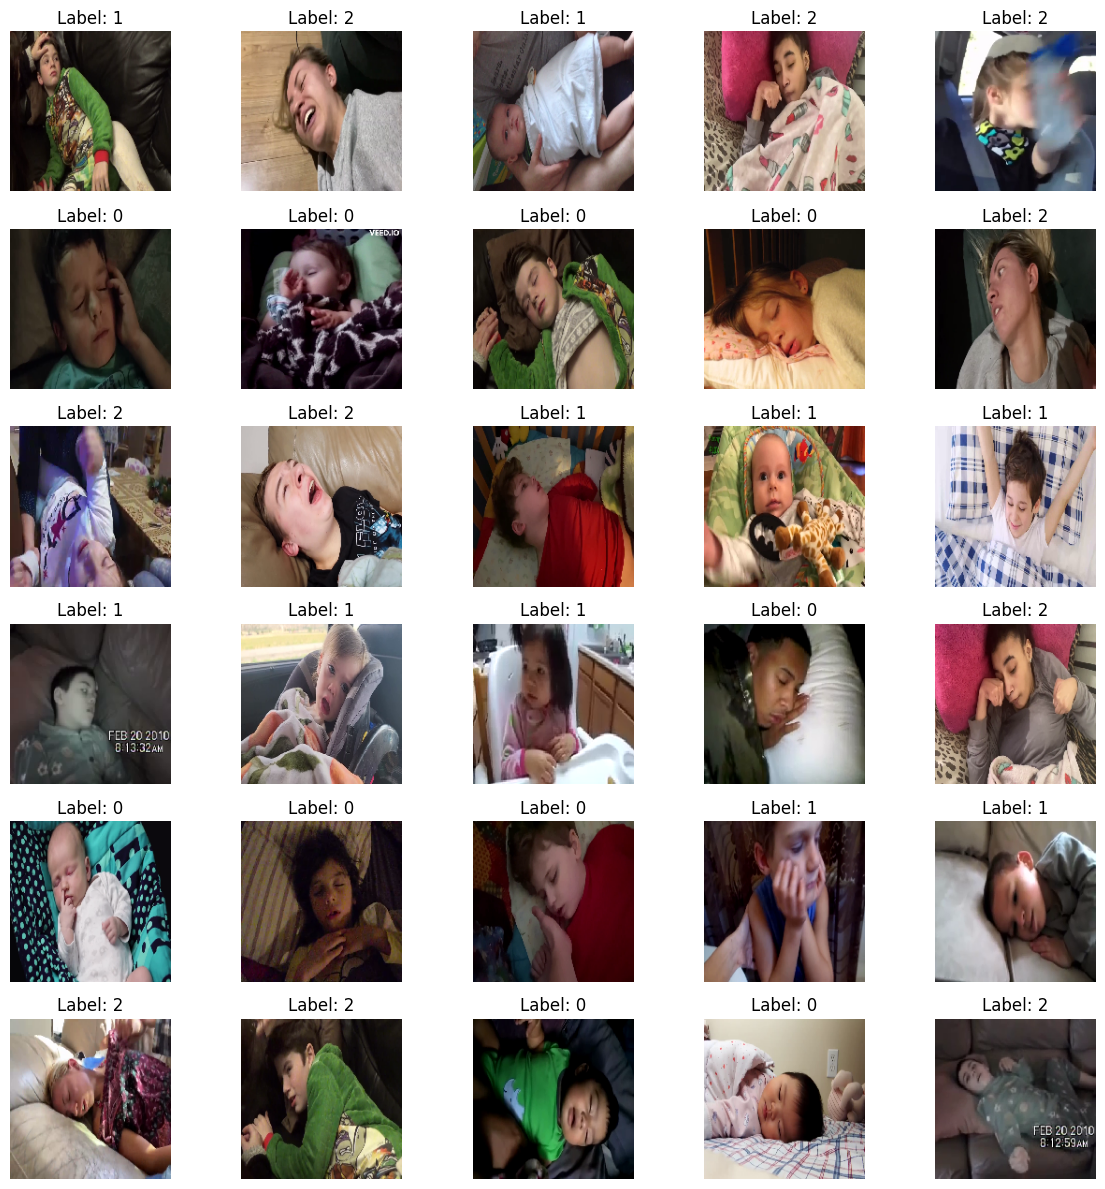

In [25]:
%matplotlib inline
plot_videos_grid (train_ds)
# If this doesn't print the first time, may need to run '%matplotlib inline' again.

In [26]:
# There seem to be some corrupted videos, inspect actual video data below. 

#for i, (frames, labels) in enumerate(train_ds):
#  print("dataset ", i)
#  tensor = tf.constant(frames)
#  frame_np = tensor[round(len(frames)/2)]
#  print(frame_np)

There are 12 videos in this dataset
Plotting below a frame from the middle of each video


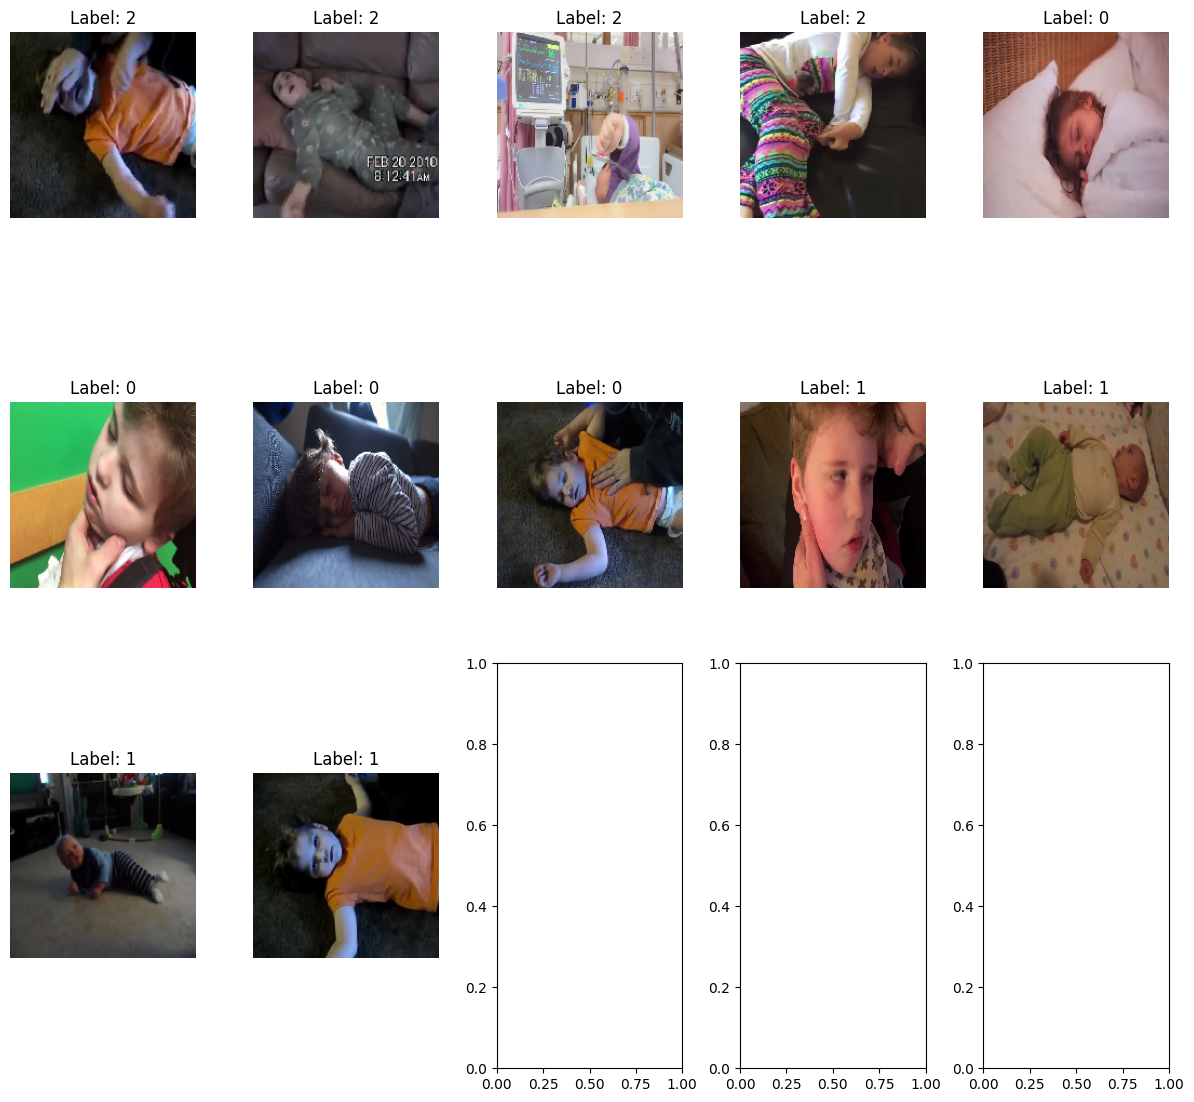

In [27]:
plot_videos_grid (test_ds)

## Show sample gifs to check on video format


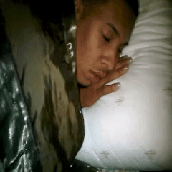

In [28]:
frames, label = list(train_ds.skip(2).take(1))[0]
to_gif(frames.numpy())


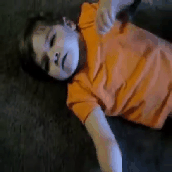

In [29]:
frames, label = list(test_ds.take(1))[0]
to_gif(frames.numpy())


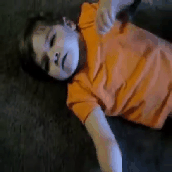

In [30]:
#frames, label = list(val_ds)[0] # The validation video is not loading appropriately. Replace whenever I have time for that. 
to_gif(frames.numpy()) #

# Augment Data

## Example on one video


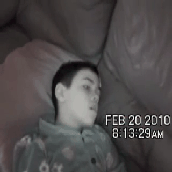

In [31]:
frames, label = list(train_ds.take(5))[0]
to_gif(frames.numpy())

In [32]:
sometimes = lambda aug: va.Sometimes(0.5, aug) # Used to apply each augmentor with 50% probability
seq1 = va.Sequential([ 
    sometimes(va.RandomCrop(size=(resolution, resolution))),
    sometimes(va.RandomRotate(degrees=10)),
    sometimes(va.VerticalFlip()),
    sometimes(va.HorizontalFlip()),
    sometimes(va.GaussianBlur(1)) 
    ], random_order=True)


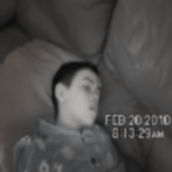

In [33]:
tensor = tf.constant(frames)
tensor_np = tensor.numpy()
video_aug_tensor = tf.convert_to_tensor(seq1(tensor_np))
to_gif(video_aug_tensor.numpy())

## Augment train and test datasets

In [34]:
def augmenter (dataset, num_augmentations=1):
  new_datasets = []
  for i, (frames, labels) in enumerate(dataset):
    print("Processing video #", i)
    new_element = (frames, labels)
    new_datasets.append(new_element)
    tensor = tf.constant(frames)
    tensor_np = tensor.numpy()
    sometimes = lambda aug: va.Sometimes(0.5, aug) # Used to apply each augmentor with 50% probability
    seq1 = va.Sequential([
        sometimes(va.RandomCrop(size=(resolution, resolution))),
        sometimes(va.RandomRotate(degrees=10)),
        sometimes(va.VerticalFlip()),
        sometimes(va.HorizontalFlip()),
        sometimes(va.GaussianBlur(1))
        ])
    for j in range(num_augmentations):
      #print("Processing augmentation #", j)
      video_aug = seq1(tensor_np)
      video_aug_tensor = tf.convert_to_tensor(video_aug)
      new_element = (video_aug_tensor, labels)
      new_datasets.append(new_element)
  return new_datasets

In [35]:
def AugGeneratorTest ():
  for element in new_datasets_test:
       frames, label = list(element)
       yield frames, label

In [36]:
new_datasets_test = augmenter (dataset = test_ds, num_augmentations=num_augmentations)

Processing video # 0
Processing video # 1
Processing video # 2
Processing video # 3
Processing video # 4
Processing video # 5
Processing video # 6
Processing video # 7
Processing video # 8
Processing video # 9
Processing video # 10
Processing video # 11


In [37]:
aug_test_ds = tf.data.Dataset.from_generator(AugGeneratorTest, output_signature=output_signature)

In [38]:
def AugGeneratorTrain ():
  for element in new_datasets_train:
       frames, label = list(element)
       yield frames, label

In [39]:
new_datasets_train = augmenter (dataset = train_ds, num_augmentations=num_augmentations)

Processing video # 0
Processing video # 1
Processing video # 2
Processing video # 3
Processing video # 4
Processing video # 5
Processing video # 6
Processing video # 7
Processing video # 8
Processing video # 9
Processing video # 10
Processing video # 11
Processing video # 12
Processing video # 13
Processing video # 14
Processing video # 15
Processing video # 16
Processing video # 17
Processing video # 18
Processing video # 19
Processing video # 20
Processing video # 21
Processing video # 22
Processing video # 23
Processing video # 24
Processing video # 25
Processing video # 26
Processing video # 27
Processing video # 28
Processing video # 29


In [40]:
aug_train_ds = tf.data.Dataset.from_generator(AugGeneratorTrain, output_signature=output_signature)

## Check the resulting videos

In [41]:
#plot_videos_grid (aug_test_ds)

In [42]:
#plot_videos_grid (aug_train_ds)

# Batch Data

In [43]:
aug_train_ds_batch = aug_train_ds.batch(batch_size)
aug_test_ds_batch = aug_test_ds.batch(batch_size)
val_ds_batch = val_ds.batch(batch_size)

 # Build Model

## Construct the backbone with proper parameters

In [75]:
model_id = model_id
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = resolution

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

## Construct the model

In [76]:
# Note: this is a temporary model constructed for the
# purpose of loading the pre-trained checkpoint. Only
# the backbone will be used to build the custom classifier.

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, num_frames, resolution, resolution, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

## Load the pretrained weights

In [77]:
# Extract pretrained weights

#!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
#!tar -xvf movinet_a0_stream.tar.gz
#checkpoint_dir = 'movinet_a0_stream'

!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a2_stream.tar.gz -O movinet_a2_stream.tar.gz -q
!tar -xvf movinet_a2_stream.tar.gz
checkpoint_dir = 'movinet_a2_stream'

checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a2_stream/
movinet_a2_stream/ckpt-1.data-00000-of-00001
movinet_a2_stream/ckpt-1.index
movinet_a2_stream/checkpoint


## Construct custom classifier with required number of classes

In [78]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes, freeze_backbone=True):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  if freeze_backbone:
    for layer in model.layers[:-(unfrozen_layers)]:
      layer.trainable = False
    model.layers[-(unfrozen_layers)].trainable = True

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  model = build_classifier(batch_size, num_frames, resolution, backbone, 3)
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

## Create a callback for storing the checkpoints

In [79]:
checkpoint_path = "/content/trained_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Train the model

In [80]:
results = model.fit(aug_train_ds_batch,
                    validation_data=aug_test_ds_batch,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/10
     33/Unknown - 50s 502ms/step - loss: 1.0485 - accuracy: 0.3879
Epoch 1: saving model to /content/trained_model/cp.ckpt
33/33 [==============================] - 72s 1s/step - loss: 1.0485 - accuracy: 0.3879 - val_loss: 0.7681 - val_accuracy: 0.7576
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.8727
Epoch 2: saving model to /content/trained_model/cp.ckpt
33/33 [==============================] - 24s 728ms/step - loss: 0.5758 - accuracy: 0.8727 - val_loss: 0.6063 - val_accuracy: 0.6970
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.9455
Epoch 3: saving model to /content/trained_model/cp.ckpt
33/33 [==============================] - 24s 728ms/step - loss: 0.3534 - accuracy: 0.9455 - val_loss: 0.5432 - val_accuracy: 0.6894
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9788
Epoch 4: saving model to /content/trained_model/cp.ckpt
33/33 [================

## Evaluate the model

In [81]:
model.evaluate(aug_test_ds_batch)

14/14 [==============================] - 7s 464ms/step - loss: 0.7052 - accuracy: 0.6212


[0.7052426934242249, 0.6212121248245239]

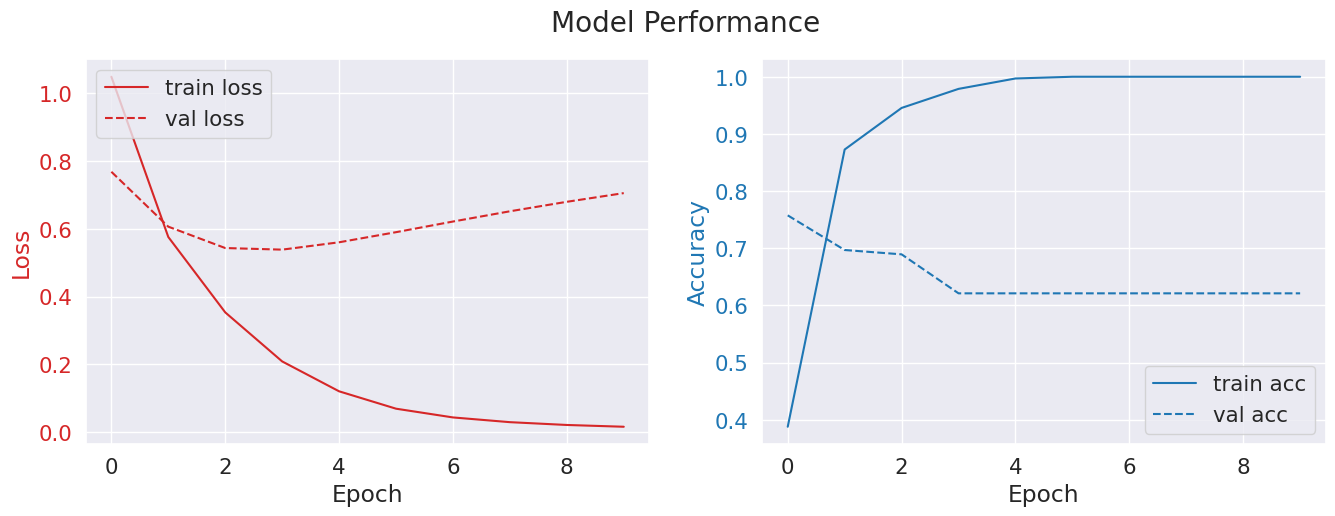

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

color = 'tab:red'
ax1.plot(results.history['loss'], color=color)
ax1.plot(results.history['val_loss'], color=color, linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['train loss', 'val loss'], loc='upper left')

color = 'tab:blue'
ax2.plot(results.history['accuracy'], color=color)
ax2.plot(results.history['val_accuracy'], color=color, linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['train acc', 'val acc'], loc='lower right')

fig.suptitle('Model Performance')
plt.show()

### Plot the test data confusion matrix

In [83]:
def get_actual_predicted_labels(dataset):
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)
  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)
  return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())
actual, predicted = get_actual_predicted_labels(aug_test_ds_batch)

14/14 [==============================] - 19s 465ms/step


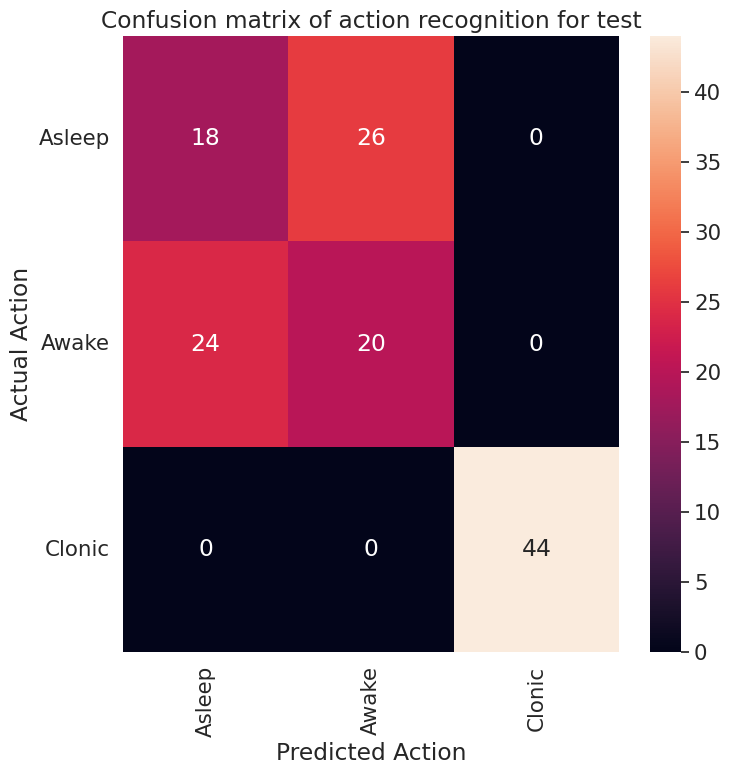

In [84]:
%matplotlib inline
plot_confusion_matrix(actual, predicted, label_names, 'test')

## Reconstruct model (`use_external_states=True`)

In [ ]:
model_id = model_id
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = resolution

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=3,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, num_frames, resolution, resolution, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

# Load weights from the checkpoint to the rebuilt model
checkpoint_dir = 'trained_model'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

## Inference using external states

In [86]:
def get_top_k(probs, k=3, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

In [87]:
# Create initial states for the stream model
init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, resolution, resolution, 3])))

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for frames, label in list(test_ds.take(1)):
  if label.numpy() == 0:
    label_str = "Asleep"
  elif label.numpy() == 1:
    label_str = "Awake"
  elif label.numpy() == 2:
    label_str = "Clonic"
  print("True label = ", label_str)
  for clip in frames:
    # Input shape: [1, 1, 172, 172, 3]
    clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
    logits, states = model.predict({**states, 'image': clip}, verbose=0)
    all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
print("Model probabilities for each label:")
for label, prob in top_k:
  print(label, prob)

True label =  Clonic

Model probabilities for each label:
Clonic 0.99953675
Awake 0.00044248355
Asleep 2.0788737e-05


# Save Models

## Export to saved model

In [88]:
saved_model_dir = '/content/model'
tflite_filename = 'model.tflite'
input_shape = [1, 1, resolution, resolution, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)

## Convert to TF Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
runner = interpreter.get_signature_runner()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']

## Export to saved model with initial states for quantization

In [91]:
saved_model_dir = '/content/model/init_states'

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=True)

## Convert to TF Lite quantized to int8 for edge devices (Raspberry Pi 3 A+)
Source: https://github.com/tensorflow/models/blob/8d92444cc4aed9a2d9746cbde882c05f4a0e748c/official/projects/movinet/tools/quantize_movinet.py

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/8d92444cc4aed9a2d9746cbde882c05f4a0e748c/official/projects/movinet/tools/quantize_movinet.py

In [ ]:
sh = """
python3 quantize_movinet.py \
--saved_model_dir='/model' \
--saved_model_with_states_dir='/model/init_states' \
--output_dataset_dir='/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model_quantized' \
--output_tflite='/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model_quantized' \
--quantization_mode='int8' \
--save_dataset_to_tfrecords=True
"""
with open('script.sh', 'w') as file:
  file.write(sh)

# !bash script.sh 
# See ValueError: `tfds_name` is , but `tfds_split` is not specified.
# This error is associated with quantize_movinet.py attempting to load the kinetics600 dataset, which is not on tfds


In [1]:
import functools
from typing import Any, Callable, Mapping, Optional
from absl import app
from absl import flags
from absl import logging
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

from official.vision.configs import video_classification as video_classification_configs
from official.vision.tasks import video_classification

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()  # BytesList won't unpack string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _build_tf_example(feature):
  return tf.train.Example(
      features=tf.train.Features(feature=feature)).SerializeToString()

def save_to_tfrecord(input_frame: tf.Tensor,
                     input_states: Mapping[str, tf.Tensor],
                     frame_index: int,
                     predictions: tf.Tensor,
                     output_states: Mapping[str, tf.Tensor],
                     groundtruth_label_id: tf.Tensor,
                     output_dataset_dir: str,
                     file_index: int):
  """Save results to tfrecord."""
  features = {}
  features['frame_id'] = _int64_feature([frame_index])
  features['groundtruth_label'] = _int64_feature(
      groundtruth_label_id.numpy().flatten().tolist())
  features['predictions'] = _float_feature(
      predictions.numpy().flatten().tolist())
  image_string = tf.io.encode_png(
      tf.squeeze(tf.cast(input_frame * 255., tf.uint8), axis=[0, 1]))
  features['image'] = _bytes_feature(image_string.numpy())

  # Input/Output states at time T
  for k, v in output_states.items():
    dtype = v[0].dtype
    if dtype == tf.int32:
      features['input/' + k] = _int64_feature(
          input_states[k].numpy().flatten().tolist())
      features['output/' + k] = _int64_feature(
          output_states[k].numpy().flatten().tolist())
    elif dtype == tf.float32:
      features['input/' + k] = _float_feature(
          input_states[k].numpy().flatten().tolist())
      features['output/' + k] = _float_feature(
          output_states[k].numpy().flatten().tolist())
    else:
      raise ValueError(f'Unrecongized dtype: {dtype}')

  tfe = _build_tf_example(features)
  record_file = '{}/movinet_stream_{:06d}.tfrecords'.format(
      output_dataset_dir, file_index)
  logging.info('Saving to %s.', record_file)
  with tf.io.TFRecordWriter(record_file) as writer:
    writer.write(tfe)


def stateful_representative_dataset_generator(
    model: tf.keras.Model,
    dataset_iter: Any,
    init_states: Mapping[str, tf.Tensor],
    save_dataset_to_tfrecords: bool = False,
    max_saved_files: int = 100,
    output_dataset_dir: Optional[str] = None,
    num_samples_per_video: int = num_frames,
    num_calibration_videos: int = 10):
  """Generates sample input data with states.

  Args:
    model: the inference keras model.
    dataset_iter: the dataset source.
    init_states: the initial states for the model.
    save_dataset_to_tfrecords: whether to save the representative dataset to
      tfrecords on disk.
    max_saved_files: the max number of saved tfrecords files.
    output_dataset_dir: the directory to store the saved tfrecords.
    num_samples_per_video: number of randomly sampled frames per video.
    num_calibration_videos: number of calibration videos to run.

  Yields:
    A dictionary of model inputs.
  """
  counter = 0
  for i in range(num_calibration_videos):
    if i % 100 == 0:
      logging.info('Reading representative dateset id %d.', i)

    example_input, example_label = next(dataset_iter)
    groundtruth_label_id = tf.argmax(tf.reshape(example_label, [1]), axis=0) # Replace original code: 'tf.argmax(example_label, axis=-1)' with tf.argmax(tf.reshape(example_label, [1]), axis=0)
    input_states = init_states
    # split video into frames along the temporal dimension.
    frames = tf.split(example_input, num_or_size_splits=num_frames, axis=0)
    frames = [tf.reshape(frame, shape=(1, 1, 172, 172, 3)) for frame in frames]

    random_indices = np.random.randint(
        low=1, high=len(frames), size=num_samples_per_video)
    # always include the first frame
    random_indices[0] = 0
    random_indices = set(random_indices)

    for frame_index, frame in enumerate(frames):
      predictions, output_states = model({'image': frame, **input_states})
      if frame_index in random_indices:
        if save_dataset_to_tfrecords and counter < max_saved_files:
          save_to_tfrecord(
              input_frame=frame,
              input_states=input_states,
              frame_index=frame_index,
              predictions=predictions,
              output_states=output_states,
              groundtruth_label_id=groundtruth_label_id,
              output_dataset_dir=output_dataset_dir,
              file_index=counter)
        yield {'image': frame, **input_states}
        counter += 1

      # update states for the next inference step
      input_states = output_states


def get_tflite_converter(
    saved_model_dir: str,
    quantization_mode: str,
    representative_dataset: Optional[Callable[..., Any]] = None
) -> tf.lite.TFLiteConverter:
  """Gets tflite converter."""
  converter = tf.lite.TFLiteConverter.from_saved_model(
      saved_model_dir=saved_model_dir)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  if quantization_mode == 'float16':
    logging.info('Using float16 quantization.')
    converter.target_spec.supported_types = [tf.float16]

  elif quantization_mode == 'int8':
    logging.info('Using full interger quantization.')
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

  elif quantization_mode == 'int_float_fallback':
    logging.info('Using interger quantization with float-point fallback.')
    converter.representative_dataset = representative_dataset

  else:
    logging.info('Using dynamic range quantization.')
  return converter

NameError: ignored

In [ ]:
encoder = hub.KerasLayer('/content/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model/init_states', trainable=False)

In [103]:
  inputs = tf.keras.layers.Input(
      shape=[1, resolution, resolution, 3],
      dtype=tf.float32,
      name='image')

  # Define the state inputs, which is a dict that maps state names to tensors.
  init_states_fn = encoder.resolved_object.signatures['init_states']
  state_shapes = {
      name: ([s if s > 0 else None for s in state.shape], state.dtype)
      for name, state in init_states_fn(
          tf.constant([1, 1, resolution, resolution, 3])).items()
  }
  states_input = {
      name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
      for name, (shape, dtype) in state_shapes.items()
  }

  # The inputs to the model are the states and the video
  inputs = {**states_input, 'image': inputs}
  outputs = encoder(inputs)
  model = tf.keras.Model(inputs, outputs, name='movinet_stream')
  input_shape = tf.constant(
      [1, num_frames, resolution, resolution, 3])
  init_states = init_states_fn(input_shape)


  # config representative_datset_fn
  representative_dataset = functools.partial(
      stateful_representative_dataset_generator,
      model=model,
      dataset_iter=iter(test_ds),
      init_states=init_states,
      save_dataset_to_tfrecords=False,
      max_saved_files=100,
      output_dataset_dir='/content/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model_quantized',
      num_samples_per_video=3,
      num_calibration_videos=10)


In [ ]:
# From https://www.tensorflow.org/lite/performance/post_training_quantization

import tensorflow as tf
saved_model_dir = '/content/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model'
quantized_dir = '/content/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model.tflite.quantized/model.tflite.quantized'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()
with open(quantized_dir, 'wb') as f:
  f.write(tflite_quant_model)

# Problems: Does not have quantize (start)/dequantize(send), and no quantization after buffer layers. 

In [ ]:
# Alternative approach
# converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model')
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.representative_dataset = representative_dataset

### Quantize weights

In [ ]:
# converter.experimental_new_converter = True
# converter.representative_dataset = representative_dataset
# tflite_quant_model = converter.convert()
# with open(quantized_dir, 'wb') as f:
#   f.write(tflite_buffer)

### Quantize for input/output

In [ ]:
# converter = get_tflite_converter(
#       saved_model_dir='/content/drive/MyDrive/Seizure_vids/Pablo_Trained_Models/model',
#       quantization_mode='int8',
#       representative_dataset=representative_dataset)

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.target_spec.supported_types = [tf.int8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8
# tflite_buffer = converter.convert()
# with open(quantized_dir, 'wb') as f:
#   f.write(tflite_buffer)

### Show details of quantized model

In [ ]:
# Load the Quantized TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=quantized_dir)
# Allocate the tensors
interpreter.allocate_tensors()
# Get the details of the model's inputs and outputs
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Get the tensor details, including the weights
tensor_details = interpreter.get_tensor_details()
print(tensor_details)

### Check inference with quantized model

In [ ]:
# Create the interpreter and signature runner

runner = interpreter.get_signature_runner()

# To run on a video, pass in one frame at a time
#init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, resolution, resolution, 3])))
states = init_states
for frames, label in list(test_ds.take(1)):
  if label.numpy() == 0:
    label_str = "Asleep"
  elif label.numpy() == 1:
    label_str = "Awake"
  elif label.numpy() == 2:
    label_str = "Clonic"
  print("True label = ", label_str)

  for clip in frames:
    # Input shape: [1, 1, 172, 172, 3]
    outputs = runner(**states, image=clip)
    logits = outputs.pop('logits')[0]
    states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
print("Model probabilities for each label:")
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames.numpy())

True label =  Asleep


ValueError: ignored

## Inference using external states on tflite model

True label =  Asleep

Model probabilities for each label:
Awake 0.72339803
Asleep 0.25864014
Clonic 0.010008978



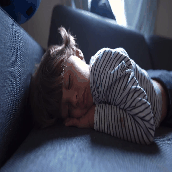

In [ ]:
# To run on a video, pass in one frame at a time
init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, resolution, resolution, 3])))
states = init_states
for frames, label in list(test_ds.take(1)):
  if label.numpy() == 0:
    label_str = "Asleep"
  elif label.numpy() == 1:
    label_str = "Awake"
  elif label.numpy() == 2:
    label_str = "Clonic"
  print("True label = ", label_str)

  for clip in frames:
    # Input shape: [1, 1, 172, 172, 3]
    outputs = runner(**states, image=clip)
    logits = outputs.pop('logits')[0]
    states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
print("Model probabilities for each label:")
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames.numpy())

# Animate Predictions Over Time

## Load gif

In [ ]:
def load_gif(file_path, image_size=(resolution, resolution)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  #video = tf.image.resize(video, image_size)
  video = tf.image.resize(video, [resolution,resolution], method='nearest')
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

 ## Get labels and probabilities function

In [ ]:
# Get top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=3, label_map=CLASSES):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  # find number of top_k labels and frames in the video
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')
  # x-axis (frame number)
  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=3,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estiamte top_k probabilities and corresponding labels
  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

## Make predictions on validation video


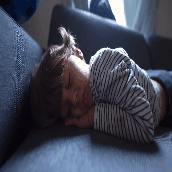

In [ ]:
#frames, label = list(val_ds.take(1))[0] # Validation video with Awake -> Clonic -> Asleep sequence
frames, label = list(test_ds.take(1))[0] # Lighter test video
to_gif(frames.numpy())

In [ ]:
video = load_gif('/content/animation.gif')
init_states = model.init_states(video[tf.newaxis].shape)
images = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for image in tqdm.tqdm(images):
  # predictions for each frame
  logits, states = model({**states, 'image': image})
  # Uncomment below if want to use faster tf.lite
  #outputs = runner(**states, image=clip)
  #logits = outputs.pop('logits')[0]
  #states = outputs
  
  all_logits.append(logits)

# concatinating all the logits
logits = tf.concat(all_logits, 0)
# estimating probabilities
probs = tf.nn.softmax(logits, axis=-1)

final_probs = probs[-1]
print('Top_k predictions and their probablities\n')
for label, p in get_top_k(final_probs):
  print(f'{label:20s}: {p:.3f}')

100%|██████████| 30/30 [00:33<00:00,  1.13s/it]

Top_k predictions and their probablities

Asleep              : 0.530
Awake               : 0.450
Clonic              : 0.010


# Generate a plot and output to a video tensor

In [ ]:
plot_video = plot_streaming_top_preds(probs, video, video_fps=3.)
media.show_video(plot_video, fps=10)

100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
